# Article Page Views API Example
This example illustrates how to access page view data using the [Wikimedia REST API](https://www.mediawiki.org/wiki/Wikimedia_REST_API). This example shows how to request monthly counts of page views for one specific article. The API documentation, [pageviews/per-article](https://wikimedia.org/api/rest_v1/#/Pageviews%20data), covers additional details that may be helpful when trying to use or understand this example.

## License
This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.3 - August 16, 2024



In [1]:
# 
# These are standard python modules
import json, time, urllib.parse
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

The example relies on some constants that help make the code a bit more readable.

In [2]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<es1@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2024',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = ['Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat']

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop", # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2024093000"    # this is likely the wrong end date
}


The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore the parameter most likely to change is the article_title.

In [3]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


# Data Loading
The function below, load_json, is used to load a json file. This is used to make most of the graphing functions fully modular (i.e. you run any of the graphing functions without having loaded the json files previously).

In [4]:
def load_json(access_type):
    
    """
    Loads a json file from the results folder
    Parameters:
        - access_type: A string with the desired access type (desktop/mobile/cumulative/etc). 
    Returns the loaded json file
    """
          
    with open(f'results/rare-disease_monthly_{access_type}_201507-202409.json', 'r') as file:
            json_file = json.load(file)  # Loads the JSON file into a dictionary
            return json_file

# Data Acquisition
The function below, create_article_title_list, is used to create a list of article names from a CSV. This is used when querying the page views for each article. In theory this function can be reused given any CSV of article names.

In [5]:
# function used to load csv files and extracts article titles

def create_article_title_list(csv_string):
    
    """
    Creates a list of article titles
    Parameters:
        - csv_string: Requires the name of the CSV containing the article titles, 
        the CSV must be in the data folder
    Returns a list of article names
    """

    wiki_csv = pd.read_csv(f"data/{csv_string}")
    article_list = wiki_csv[["disease"]].values.flatten().tolist()
    return article_list

The function below, write_page_view_json, is used to write a json file given an access_type and article list. This function is used to get the full json files for desktop, mobile-web, and mobile-app.

In [6]:
# function used to write page gives to a json given an access type and article list

def write_page_view_json(access_type, article_list):

    """
    Creates a list of article titles
    Parameters:
        - access_type: A string with the desired access type (desktop/mobile/cumulative/etc).
        - article_list: List of article titles
    Writes a full json file
    """

    full_dict = dict()
    ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE["access"] = access_type

    for article in article_list:       
        views = request_pageviews_per_article(article)
        if 'items' not in views: # checks to see if the article is valid, if not, skip.
            print(f"The following article was not included: {article}") 
            continue
        
        hold_article_info = list()
        for month in views['items']:
            # remove the access information from each timestamp
            rewritten_month = {k: v for k, v in month.items() if k != 'access'} 
            hold_article_info.append(rewritten_month)
        
        full_dict[article] = hold_article_info

    with open(f'results/rare-disease_monthly_{access_type}_201507-202409.json', 'w') as outfile:
        json.dump(full_dict, outfile, indent=4)

# Data Processing

The function below, combine_page_views, is used to combine the page views each month given two access_types. This is used to get the full mobile page views (mobile-web + mobile-app) and the cumulative (mobile + desktop).

In [7]:
# function that combines page views given two access types - then writes to new json

def combine_page_views(access_types, final_name):

    """
    Combines the page views of two json files
    Parameters:
        - access_type: A string with the desired access type (desktop/mobile/cumulative/etc).
        - final_name: The file name used to save the combined json
    Saves the combined page view json file
    """

    # loads the json files used 
    access_type_file_1 = load_json(access_types[0])
    access_type_file_2 = load_json(access_types[1])

    # initializes the combined json, this file will have the page views updated
    combined = access_type_file_1.copy()

    for article_name in access_type_file_1.keys():

        # Checks that mobile_web and mobile_app have the same length
        if len(access_type_file_1[article_name]) == len(access_type_file_2[article_name]):

            for month in range(len(access_type_file_1[article_name])):
                #print(month)
                file_1_views = access_type_file_1[article_name][month].get('views')  
                file_2_views = access_type_file_2[article_name][month].get('views')  
                # Sum the views and updates combined's 'views' key
                combined[article_name][month]['views'] = file_1_views + file_2_views

    with open(f'results/rare-disease_monthly_{final_name}_201507-202409.json', 'w') as outfile:
        json.dump(combined, outfile, indent=4)

# Data Analysis/Visualization

The helper function below, get_views_and_timestamps takes in a list of timestamps for an article and converts them to datetime. This is used when plotting time series data to ensure all articles are properly aligned. 

In [8]:
def get_views_and_timestamps(disease_data):

    """
    Used for plotting articles views by converting their dates into datetime format
    Parameters:
        - disease_data: A list of timestamps for a given article
    Returns two lists, the views and the datetime timestamps for a given article
    """
    
    views = []
    timestamps = []
    for entry in disease_data:
        views.append(entry.get('views', 0))
        timestamp_str = entry.get('timestamp', '')
        timestamp = datetime.strptime(timestamp_str, "%Y%m%d%H")  # Convert timestamp to datetime
        timestamps.append(timestamp)
    return views, timestamps

Given a list of two access types, the function below, max_min_average, is used to get the most popular and least popular article by average page requests. The results are then returned. This is used to generate graph 1.

In [9]:
# function that creates graph 1 given link to dataset
def max_min_average(access_types):

    """
    Find the most popular and least popular articles given two access types.
    Parameters:
        - access_types: A list of strings with the desired access type (desktop/mobile/cumulative/etc).
    Returns a dictionary where the keys are the access types 
    and the values are information about the most and least popular article
    """
    
    results = {}

    for access_type in access_types:
        access_type_data = load_json(access_type)

        disease_max_avg = None
        disease_min_avg = None
        max_avg_views = float('-inf')  # Set to negative infinity initially to find the maximum
        min_avg_views = float('inf')    # Set to infinity initially to find the minimum

        for disease, timestamps in access_type_data.items():

            # Calculate the total views for the current disease
            total_views = sum(timestamp.get('views', 0) for timestamp in timestamps)
            avg_views = total_views / len(timestamps) if timestamps else 0  # Handle division by zero
            
            # Update max_avg_views and disease_max_avg
            if avg_views > max_avg_views:
                max_avg_views = avg_views
                disease_max_avg = disease
            
            # Update min_avg_views and disease_min_avg
            if avg_views < min_avg_views:
                min_avg_views = avg_views
                disease_min_avg = disease

        # Store results for the current access type
        results[access_type] = {
            'max_disease': disease_max_avg,
            'max_avg_views': max_avg_views,
            'min_disease': disease_min_avg,
            'min_avg_views': min_avg_views,
        }

    return results

The function below, plot_views, is used to plot the results generated from the function max_min_average, this then displays a plot for Step 2 Graph 1. This creates a time series line graph where each line is an article and the views are charted over the years.

In [27]:
# Plotting function
def plot_views(results):

    """
    Given a dictionary of results from max_min_average, plots the time series.
    Parameters:
        - results: A dictionary with the two access types and the most and least popular articles.
    Creates a plot of the results
    """

    plt.figure(figsize=(12, 6))

    for access_type, data in results.items():
        access_type_file = load_json(access_type)
        
        # Plot max disease
        max_disease = data['max_disease']
        max_views, max_timestamps = get_views_and_timestamps(access_type_file.get(max_disease, []))
        plt.plot(max_timestamps, max_views, label=f"{access_type.capitalize()} - Max: {max_disease}", marker='o')

        # Plot min disease
        min_disease = data['min_disease']
        min_views, min_timestamps = get_views_and_timestamps(access_type_file.get(min_disease, []))
        plt.plot(min_timestamps, min_views, label=f"{access_type.capitalize()} - Min: {min_disease}", marker='x')

    # Format x-axis with dates
    plt.gcf().autofmt_xdate()  # Auto format date labels to avoid overlap

    # Add labels and title
    plt.xlabel("Date (Timestamp)")
    plt.ylabel("Views")
    plt.title("Views Over Time for Most and Least Popular Diseases")
    plt.legend()
    plt.grid(True)

    plt.savefig(f"figures/min_max_average.png", format='png', dpi=300)  # Save the figure with high resolution
    # Show the plot
    plt.show()

The function below, get_peak_views, takes in a dictionary where the keys are articles, and the values are a list of timestamps with page views and returns the peak view for each disease. This is used in the generation of the top 10 peak page views graph. 

In [11]:
# Helper function to get peak views for each disease
def get_peak_views(disease_dict):

    """
    Given a dictionary of articles and timestamps, returns the peak views for each article.
    Parameters:
        - disease_dict: A dictionary where the keys are disease articles and the values are timestamps containing views information.
    Returns a dictionary where the keys are the disease articles, and the values are the peak views for that article.
    """

    peak_views = {}
    for disease, timestamps in disease_dict.items():
        views = [entry.get('views', 0) for entry in timestamps]
        peak_views[disease] = max(views) if views else 0  # Get the max view (peak)
    return peak_views

The function below, get_disease_length, takes in a dictionary where the keys are article titles, and the values are a list of timestamps and then returns the number of timestamps for each disease. This is used to generate Graph 3 - which is the find the diseases with the fewest months of data.

In [12]:
# Helper function to count the number of timestamps for each disease
def get_disease_length(disease_dict):

    """
    Given a dictionary of articles and timestamps, returns the number of timestamps the disease has
    Parameters:
        - disease_dict: A dictionary where the keys are disease articles and the values are timestamps containing views information.
    Returns a dictionary where the keys are the disease articles, and the values are the number of timestamps.
    """

    disease_lengths = {}
    
    for disease, timestamps in disease_dict.items():
        disease_lengths[disease] = len(timestamps)
    
    return disease_lengths

The function below, plot_disease_views, takes in a dictionary of dictionaries where the keys are access_type, and the values are dictionaries where the keys are articles and the values are timestamps. The function also takes in a plot title, and a list of access type strings, and plots the views and timestamps for the desired articles. This function is used to generate the plots for both Graph 2 and Graph 3. 

In [22]:
def plot_disease_views(disease_dict, title, access_type_labels, filename):
    """
    Plots views over time for the specified diseases.
    
    Parameters:
        disease_dict: A dictionary with access types as keys, 
                             each containing a list of diseases to plot.
        title: The title of the plot.
        access_type_labels: List of labels for the access types).
        Returns a plot
    """
    plt.figure(figsize=(20, 8))


    for access_type, diseases in disease_dict.items():
        for disease in diseases:

            views, timestamps = get_views_and_timestamps(disease_dict[access_type].get(disease, []))
            plt.plot(timestamps, views, label=f"{access_type_labels[0]} - {disease}", marker='o' if access_type_labels[0] == "Desktop" else 'x')

    # Format the x-axis with date labels
    plt.gcf().autofmt_xdate()

    # Add labels and title
    plt.xlabel("Date (Timestamp)")
    plt.ylabel("Views")
    plt.title(title)
    # Adjust legend properties
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=1, frameon=True)
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.savefig(f"figures/{filename}.png", format='png', dpi=300)  # Save the figure with high resolution
    plt.show()

The function below, plot_fewest_months, is used to contain the processes needed to generate Graph 3 which is to plot the diseases with the fewest months of data. It takes in access_types and then returns the top 10 articles with the fewest months.

In [23]:
# Function to get the top 10 diseases by fewest months of data
def plot_fewest_months(access_types):
    """
    Plots views over time for the top 10 articles with the fewest months of data.
    
    Parameters:
        access_types: A list of strings with the desired access type (desktop/mobile/cumulative/etc).
        Returns a plot for graph 3
    """

    # loads in the json files for each access_type
    access_type_file_1 = load_json(access_types[0])
    access_type_file_2 = load_json(access_types[1])

    # gets the number of timestamps for each article for each access_type
    file_1_lengths = get_disease_length(access_type_file_1)
    file_2_lengths = get_disease_length(access_type_file_2)

    # gets the top 10 articles by fewest number of timestamps
    top_10_fewest_type_1 = sorted(file_1_lengths, key=file_1_lengths.get)[:10]
    top_10_fewest_type_2 = sorted(file_2_lengths, key=file_2_lengths.get)[:10]

    disease_dict = {
        f"{access_types[0]}": {disease: access_type_file_1[disease] for disease in top_10_fewest_type_1},
        f"{access_types[1]}": {disease: access_type_file_2[disease] for disease in top_10_fewest_type_2}
    }

    plot_disease_views(disease_dict, f"Articles with Fewest Months of Data ({access_types[0]} and {access_types[1]})", access_types, "fewest_months")


The function below, plot_peak_views, is used to contain the processes needed to generate Graph 2 which is to plot the diseases with the fewest months of data. It takes in access_types and then returns the top 10 articles with the highest peak views.

In [24]:
# Function to get the top 10 diseases by peak views
def plot_peak_views(access_types):

    """
    Plots views over time for the top 10 articles with the highest peak views.
    
    Parameters:
        access_types: A list of strings with the desired access type (desktop/mobile/cumulative/etc).
        Returns a plot for graph 2
    """

    # loads in the json files for each access_type
    access_type_file_1 = load_json(access_types[0])
    access_type_file_2 = load_json(access_types[1])

    # gets the peak number of views for each article
    file_1_peak_views = get_peak_views(access_type_file_1)
    file_2_peak_views = get_peak_views(access_type_file_2)

    # gets the top 10 articles by highest number of peak views
    top_10_type_1 = sorted(file_1_peak_views, key=file_1_peak_views.get, reverse=True)[:10]
    top_10_type_2 = sorted(file_2_peak_views, key=file_2_peak_views.get, reverse=True)[:10]

    disease_dict = {
        f"{access_types[0]}": {disease: access_type_file_1[disease] for disease in top_10_type_1},
        f"{access_types[1]}": {disease: access_type_file_2[disease] for disease in top_10_type_2}
    }

    plot_disease_views(disease_dict, f"Top 10 Articles by Peak Views ({access_types[0]} and {access_types[1]})", access_types, "peak_views")


# Script execution (Data Analysis)

The cell below starts the process by creating a list of disease titles from the provided CSV

In [16]:
# loads in list of articles to use - in this case disease
article_list = create_article_title_list('rare-disease_cleaned.AUG.2024.csv')

The cell below writes json files to the results file given the access type and article list. In this case it writes and saves desktop, mobile-web, and mobile-app.

In [17]:
# creates json files of desired access types given article list
write_page_view_json("desktop", article_list)
write_page_view_json("mobile-web", article_list)
write_page_view_json("mobile-app", article_list)

The cell below combines mobile-web and mobile-app to get the mobile page views, then saves that to a json file. It then repeats the process to get the cumulative page views from the desktop and mobile json files.


In [18]:
# combines json files to get combined page views

combine_page_views(["mobile-web", "mobile-app"], "mobile")
combine_page_views(["desktop", "mobile"], "cumulative")

The script below generates the plot for graph 1 of the analysis

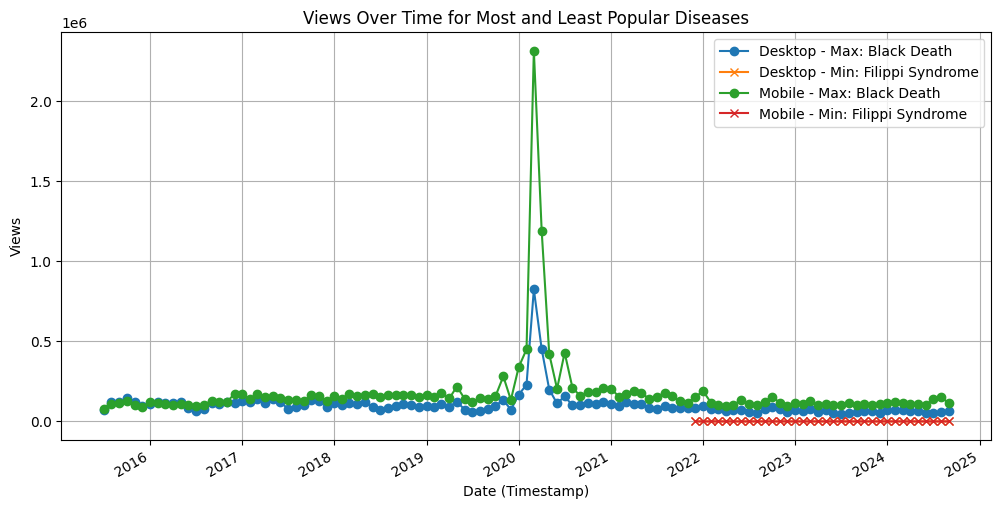

In [28]:
# Call the function and plot (graph 1)
results = max_min_average(["desktop", "mobile"])
plot_views(results)

The script below generates the plot for graph 2 of the analysis

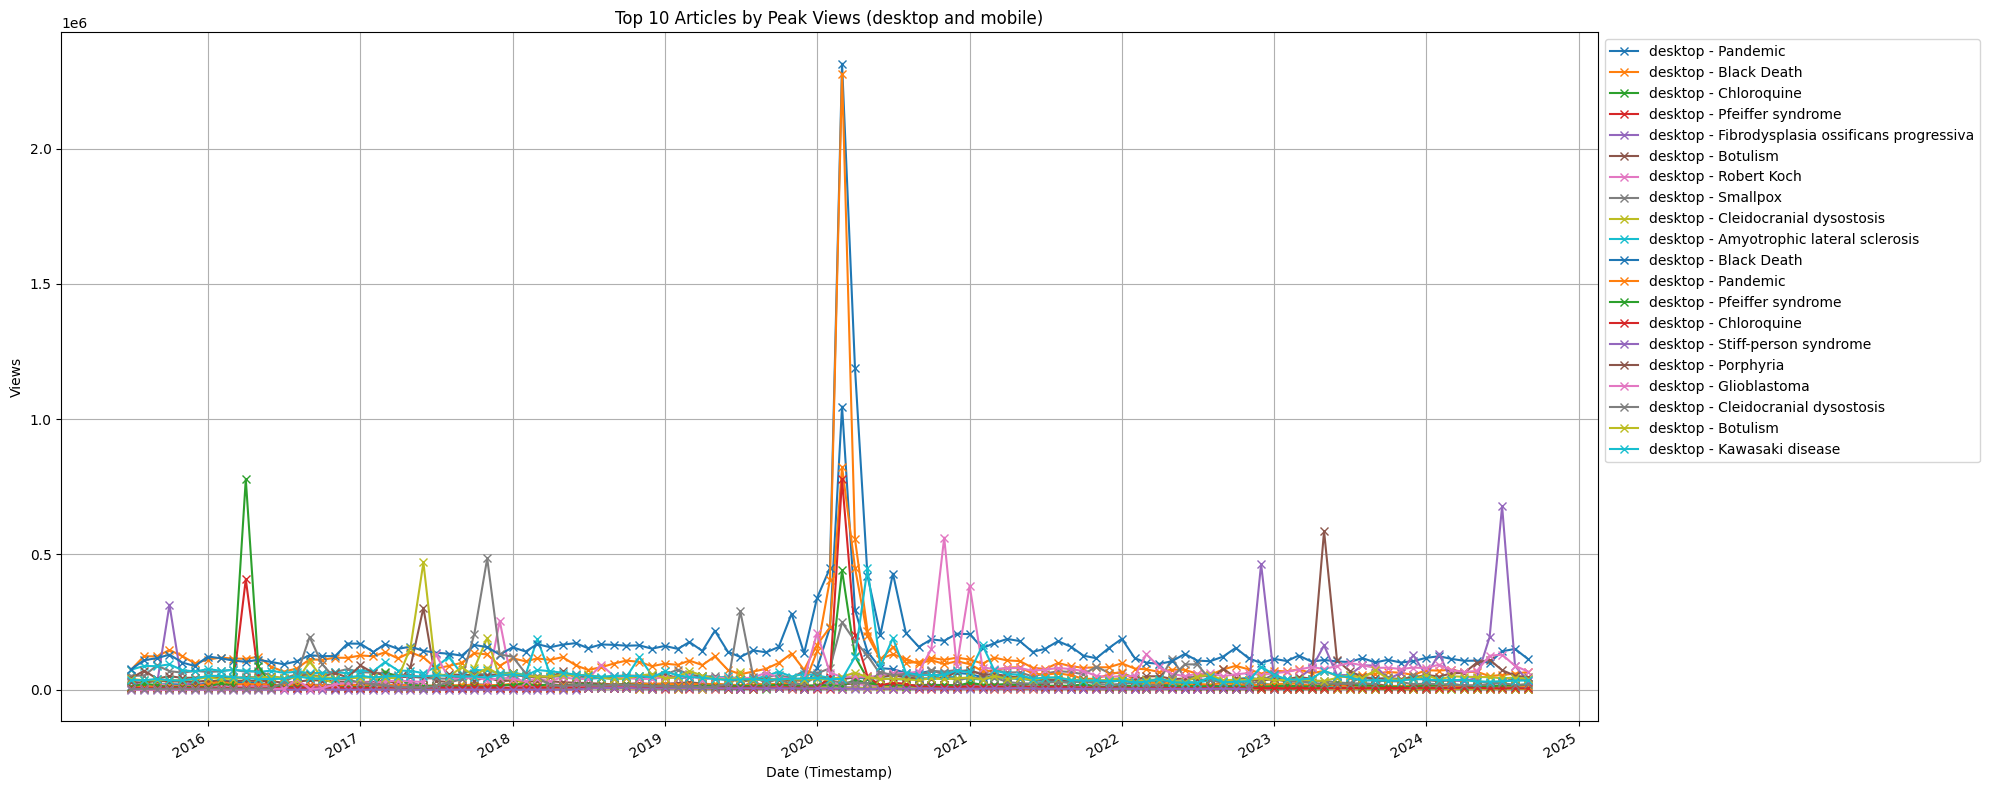

In [25]:
# Call the function and plot (graph 2)
plot_peak_views(["desktop", "mobile"])

The script below generates the plot for graph 3 of the analysis

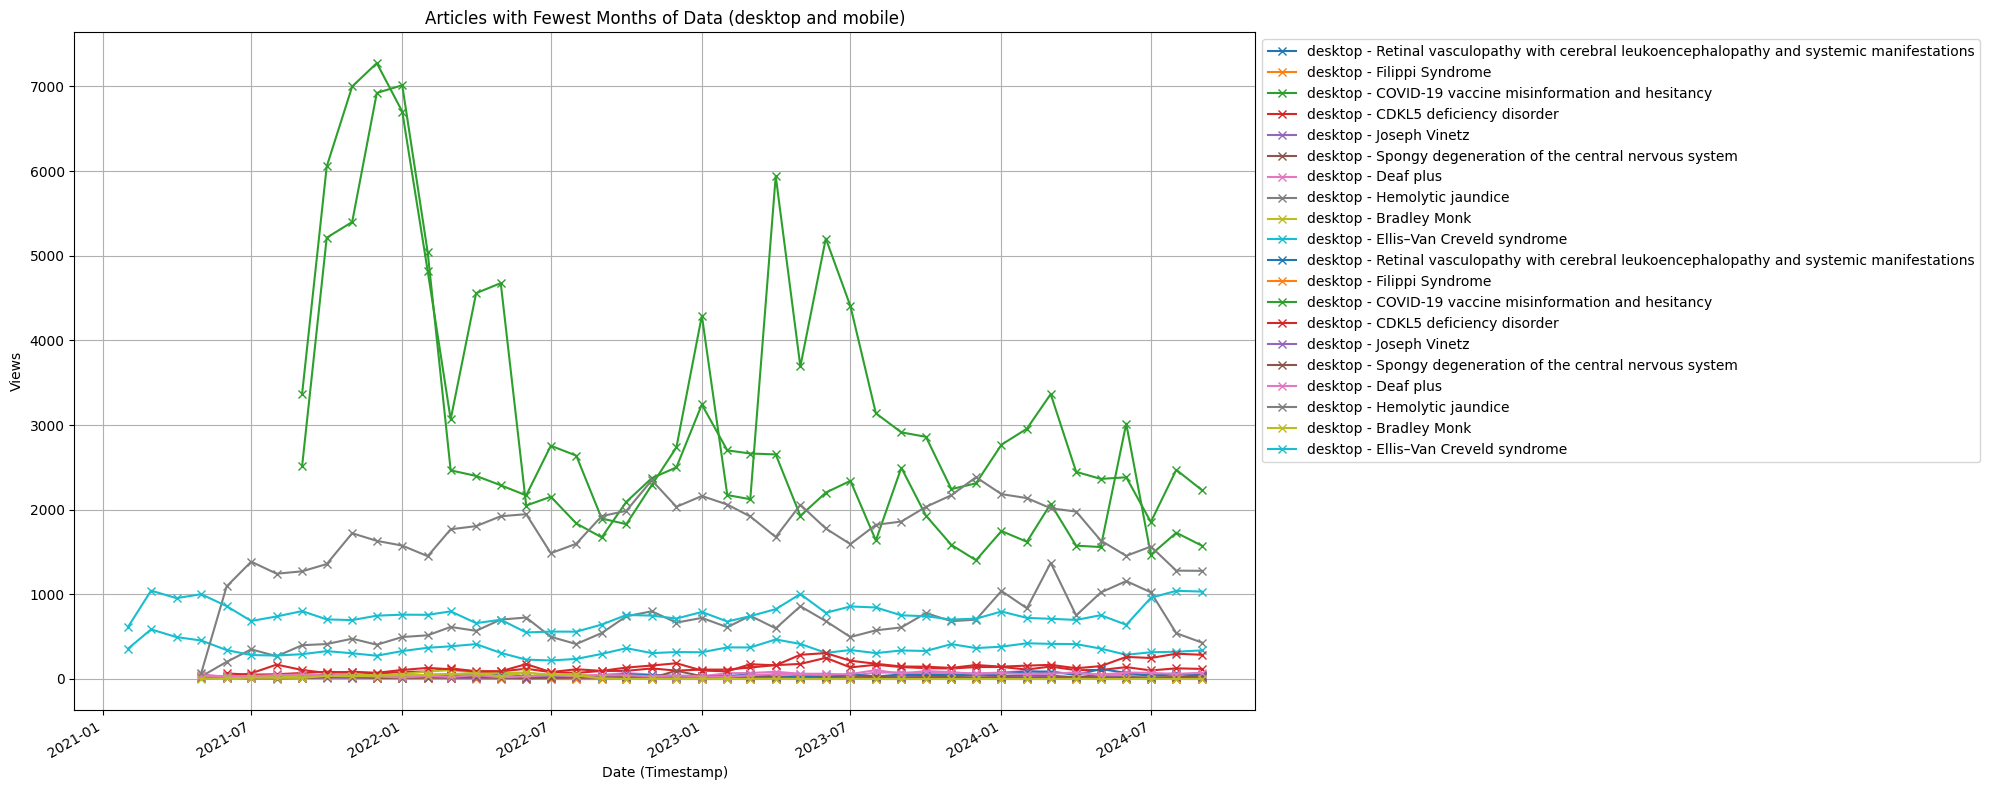

In [26]:
# Call the function and plot (graph 3)
plot_fewest_months(["desktop", "mobile"])